In [1]:
from qiskit import *
from qiskit.circuit import Parameter
from math import pi
from copy import deepcopy
import numpy as np

Bell states in the basis $\{|00\rangle, |01\rangle, |10\rangle, |11\rangle\}$ as numpy arrays

In [2]:
phi_plus = np.array([1, 0, 0, 1])/np.sqrt(2)   # | Phi^+ >
phi_minus = np.array([1, 0, 0, -1])/np.sqrt(2) # | Phi^- >
psi_plus = np.array([0, 1, 1, 0])/np.sqrt(2)   # | Psi^+ >
psi_minus = np.array([0, 1, -1, 0])/np.sqrt(2) # | Psi^- >

In [3]:
qr = QuantumRegister(4) # create register to store bits

We need source circuit that creates the following state $|\psi_\textrm{S} \rangle$ between two qubits,

$$
|\psi_\textrm{S}\rangle = \cos\left(\frac{\theta}{2}\right) |01\rangle - \sin\left(\frac{\theta}{2}\right) |10\rangle ,
$$

$$
F \equiv F(\theta) = \langle \Psi^- | \rho_\textrm{S} | \Psi^- \rangle  = \frac{1}{2} \left( \sin(\theta) + 1 \right).
$$

By taking the expactation value of density matrix we get: theta = np.arcsin(2*F - 1),


for F=0.75:


In [4]:

theta = np.arcsin(2*0.75 - 1)
    


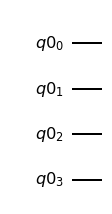

In [5]:
source_circ = QuantumCircuit(qr)
%matplotlib inline
source_circ.draw(output='mpl')

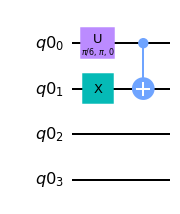

In [6]:
source_circ.x(qr[1]);

source_circ.u(theta, pi, 0, qr[0]);

source_circ.cx(qr[0], qr[1]);
source_circ.draw(output='mpl')

We need two copies of the state $\rho_\textrm{S}$ to perform entanglement purification, we also need to set qubits 2 and 3 to the source state $|\psi_\textrm{S}\rangle$,

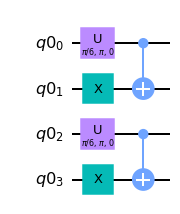

In [7]:
source_circ.x(qr[3])

source_circ.u(theta, pi , 0, qr[2])

source_circ.cx(qr[2], qr[3])

source_circ.draw(output='mpl')

In [8]:
control_qubits = [qr[0], qr[1]]
target_qubits = [qr[2], qr[3]]

To implement the twirl operation, we create another quantum circuit

In [9]:
twirl_circ = QuantumCircuit(qr)

To implement an operation we randomly select an element from the set of 12 bilateral operations $\{U_i\}$ and apply the corresponding rotations locally to their qubit.

In [10]:
def bilateral_rotation(circuit, qubits, rot_idx):
   
    for qubit in qubits:
        if rot_idx == 0:
            pass
        
        elif rot_idx == 1:
            circuit.rx(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 2:
            circuit.ry(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 3:
            circuit.rz(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 4:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 5:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 6:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 7:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 8:
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            
        elif rot_idx == 9:
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            
        elif rot_idx == 10:
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.rz(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            
        elif rot_idx == 11:
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)
            circuit.ry(pi/2, qubit)
            circuit.rx(pi/2, qubit)

In [11]:
# Create a random integer between 0 and 11
random_idx = np.random.randint(12)

# Add a random bilateral rotation to the circuit, applied to qubits 0 and 1 (control qubits)
bilateral_rotation(twirl_circ, control_qubits, random_idx)

# Add a random bilateral rotation to the circuit, applied to qubits 2 and 3 (target qubits)
bilateral_rotation(twirl_circ, target_qubits, random_idx)

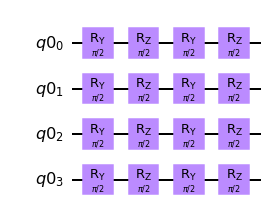

In [12]:
twirl_circ.draw(output='mpl')

Add the $Y$ gates to the corresponding qubits to swap $|\Psi^-\rangle$ and $|\Phi^+\rangle$ components

In [13]:
purification_circ = QuantumCircuit(qr)

# Implement a Pauli-Y gate on Alice's control qubit
purification_circ.y(control_qubits[0])

# Implement a Pauli-Y gate on Alice's target qubit
purification_circ.y(target_qubits[0])



Alice and Bob apply a bilateral CNOT gate

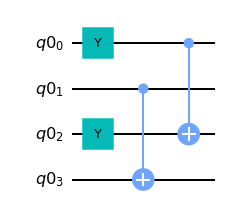

In [14]:
purification_circ.cx(control_qubits[0], target_qubits[0])
purification_circ.cx(control_qubits[1], target_qubits[1])
purification_circ.draw(output='mpl')

The entire quantum circuit for the purification experiment :

<ipython-input-15-70cc6feba34b>:1: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  experiment_circ = source_circ + twirl_circ + purification_circ
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


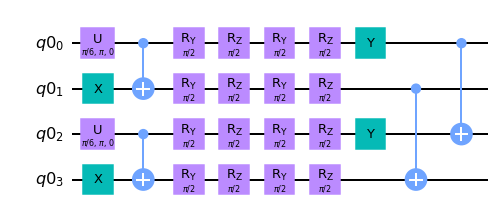

In [15]:
experiment_circ = source_circ + twirl_circ + purification_circ
experiment_circ.draw(output='mpl')

To reconstruct the density matrix $\rho'_{F'}$, we can use methods of quantum tomography.

In [16]:
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

In [17]:
tomography_circs = state_tomography_circuits(experiment_circ, control_qubits)

C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:398: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  prep_qubit_registers = set(q.register for q in prep_qubits)
C:\U

Circuit obtained is a list of quantum circuits and from the measurement results of all these circuits the state $\rho'_{F'}$ can be reconstructed.

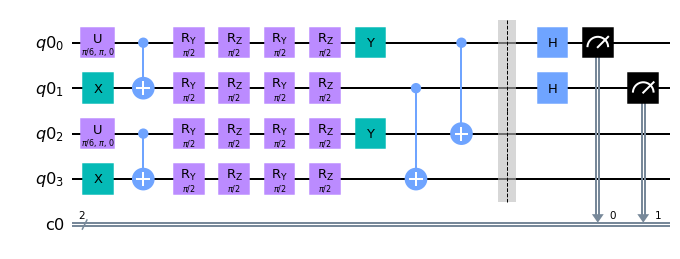

In [18]:
tomography_circs[0].draw(output='mpl')

Purification only worked if the target qubits were measured and the measurements gave the same results.

Apply conditional state tomography, that the tomography is only performed if the target qubits were previously measured either both in the state $|0\rangle$ or both in the state $|1\rangle$. This corresponds exactly to the discarding of all failed purifications.



The conditional state tomography is thus implemented as follows. First we make a copy of our original circuit experiment_circ:

In [19]:
ancilla_circ = deepcopy(experiment_circ)

We then add a classical register to ancilla_circ which is an instance of the class ClassicalRegister to store the results of the measurement of the target qubits. We need a two-bit register here:

In [20]:
# Create a classical register cr consisting of two bits
cr = ClassicalRegister(2)

# Add the classical register to the circuit
ancilla_circ.add_register(cr)

Next, we must actually add the measurements of the target qubits.

In [21]:
ancilla_circ.measure(target_qubits[0], cr[0])

ancilla_circ.measure(target_qubits[1], cr[1]);

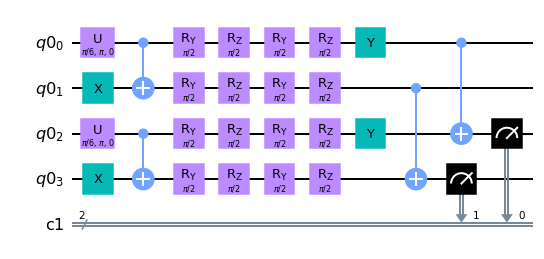

In [22]:
ancilla_circ.draw(output='mpl')

For the circuit ancilla_circ we also create tomography circuits ancilla_tomography_circs using the function state_tomography_circuits to reconstruct the state of the control qubits:

In [23]:
ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)

C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:398: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  prep_qubit_registers = set(q.register for q in prep_qubits)
C:\U

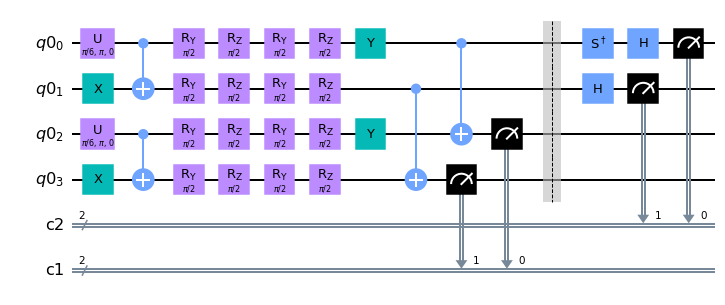

In [24]:
ancilla_tomography_circs[3].draw(output='mpl')

In this part we will simulate the quantum circuit for the BBPSSW protocol. To demonstrate a successful purification, we calculate an average of many quantum systems to generate approximately the state $\rho'_{F'}$ and extract the purified fidelity $F'$

In [25]:
backend = Aer.get_backend('qasm_simulator')
result = execute(tomography_circs, backend = backend, shots = 5000).result()
result.get_counts()

[{'00': 4374, '11': 626},
 {'00': 2223, '01': 286, '10': 2209, '11': 282},
 {'00': 2144, '01': 322, '10': 2213, '11': 321},
 {'00': 2174, '01': 2188, '10': 305, '11': 333},
 {'00': 648, '01': 1872, '10': 1881, '11': 599},
 {'00': 1249, '01': 1277, '10': 1251, '11': 1223},
 {'00': 2181, '01': 2143, '10': 330, '11': 346},
 {'00': 1265, '01': 1241, '10': 1219, '11': 1275},
 {'00': 1850, '01': 603, '10': 650, '11': 1897}]

The fitter provides a method fit that returns the reconstructed density matrix 

In [26]:
fitter = StateTomographyFitter(result, tomography_circs).fit()

For an ensemble:

In [27]:
def experiment_circuit(index):
    """ Returns experiment circuit corresponding to an index.
       
    """
    if index < 0 or index > 11:
        raise Exception("Index for bilateral rotation exceeds range of possible values.")
        
    # Create twirl circuit from the bilateral rotations
    twirl_circ = QuantumCircuit(qr)
    bilateral_rotation(twirl_circ, control_qubits, index)
    bilateral_rotation(twirl_circ, target_qubits, index)
    
    experiment_circ = source_circ + twirl_circ + purification_circ
    
    return experiment_circ

In [28]:
def ancilla_circuit(quantum_circuit, qubits):
    """ Return an ancilla circuit that includes additional measurements.
    """
    
    # Copy original circuit
    ancilla_circ = deepcopy(quantum_circuit)
    
    # Add classical register
    cr = ClassicalRegister(len(qubits))
    ancilla_circ.add_register(cr)
    
    # Measure qubits
    for i, qubit in enumerate(qubits):
        ancilla_circ.measure(qubit, cr[i])
    
    return ancilla_circ

In [29]:
def conditional_tomography_circuits(quantum_circuit):
    """ Returns all tomography circuits for conditional quantum state tomography. 
    """
    # Create ancilla circuit
    ancilla_circ = ancilla_circuit(quantum_circuit, target_qubits)
    
    # Create tomography circuits
    tomography_circs = state_tomography_circuits(quantum_circuit, control_qubits)
    ancilla_tomography_circs = state_tomography_circuits(ancilla_circ, control_qubits)
    
    return tomography_circs, ancilla_tomography_circs

In [30]:
def purification_shots(job_results):
    """ Keep counts for successful purifications and return corresponding result.
    
    Keyword arguments:
    job_results -- execution results
    
    Returns:
    conditional_results -- results without unsuccessful shots
    """
    # Copy original results
    conditional_results = deepcopy(job_results)
    
    for ii,_ in enumerate(job_results.results):
        counts = job_results.get_counts(ii)
        conditional_counts = {}
        
        # Keep counts of successful purifications
        for result, count in counts.items():
            target_measurement = result.split(' ')[0]
            control_measurement = result.split(' ')[1]

            if target_measurement in ('00', '11'):
                if control_measurement in conditional_counts:
                    conditional_counts[control_measurement] = conditional_counts[control_measurement] + count
                else:
                    conditional_counts[control_measurement] = count
        
        # Adapt the properties of conditional_results accordingly
        conditional_results.results[ii].data.counts = conditional_counts
        conditional_results.results[ii].header.clbit_labels = conditional_results.results[ii].header.clbit_labels[0:2]
        conditional_results.results[ii].header.creg_sizes = [conditional_results.results[ii].header.creg_sizes[0]]
        conditional_results.results[ii].header.memory_slots = 2
            
    return conditional_results

 To save the tomography circuits and the corresponding execution job:

In [31]:
def job_dictionary(circuits, job):
    
   
    job_dict = {}
    job_dict["circuits"] = circuits
    job_dict["job"] = job
    
    return job_dict

When a job has been executed, a density matrix can be reconstructed from a dictionary returned by the above function using the function rho_from_dict

In [32]:
def rho_from_dict(job_dict, cond_tomo):
    
    if cond_tomo:
        # Conditional quantum state tomography
        conditional_results = purification_shots(job_dict["job"].result())
        rho_fit = StateTomographyFitter(conditional_results, job_dict["circuits"]).fit()
    else:
        # Regular quantum state tomography
        rho_fit = StateTomographyFitter(job_dict["job"].result(), job_dict["circuits"]).fit()
    
    return rho_fit

In [33]:
def execute_purification(F_in, index, backend, shots, noise_model=None, coupling_map=None, basis_gates=None,
                         remove_barriers=False):
    """ Execute entire BBPSSW protocol on a target backend.
    
    Keyword arguments:
    F_in            -- input fidelity
    index           -- integer between 0 and 11, defines bilateral rotation
    backend         -- backend to execute circuits
    shots           -- number of shots per execution
    
    Returns:
    job_dict -- dictionary containing execution job and tomography circuits
    """
    # Create experiment circuit and corresponding tomography circuits
    experiment_circ = experiment_circuit(index)
    tomography_circs, ancilla_tomography_circs = conditional_tomography_circuits(experiment_circ)
    
    # Remove barriers
    if remove_barriers:
        ancilla_tomography_circs[:] = [_remove_barriers(circ) for circ in ancilla_tomography_circs]
    
    # Execute tomography circuits on simulator (w/ noise parameters) or real device (w/o noise parameters)
    if backend.configuration().simulator == True:
        job = execute(ancilla_tomography_circs, backend, shots=shots,
                      noise_model=noise_model, coupling_map=coupling_map, basis_gates=basis_gates)
    else:   
        job = execute(ancilla_tomography_circs, backend, shots=shots)
    
    # Construct job dictionary
    job_dict = job_dictionary(tomography_circs, job)
    
    return job_dict

Apply the protocol to  𝑁  quantum systems and averaging across all systems. Here, each execution run varies in the random selection of the bilateral rotation. 

In [34]:
N = 100
F = 0.75

# Empty list for storing the reconstructed density matrices of all runs
fitted_states = []

# Perform runs
for ii in range(N):
    # Create experiment circuit and corresponding tomography circuits
    random_idx = np.random.randint(12)
    experiment_circ = experiment_circuit(random_idx)
    tomography_circs, ancilla_tomography_circs = conditional_tomography_circuits(experiment_circ)
    
    # Execute ancilla tomography circuits on simulator
    job = execute(ancilla_tomography_circs, backend, shots=1024)
    job_results = job.result()
    
    # Keep counts of successful purifications
    conditional_results = purification_shots(job_results)

    # Reconstruct density matrix of control qubits
    rho_fit = StateTomographyFitter(conditional_results, tomography_circs).fit()
    
    # Add reconstructed density matrix to list
    fitted_states.append(rho_fit)
    
# Calculate average density matrix
rho_average = sum(fitted_states)/N

C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:391: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  meas_qubit_registers = set(q.register for q in meas_qubits)
C:\Users\asuss\anaconda3\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:398: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  prep_qubit_registers = set(q.register for q in prep_qubits)
C:\U

We use the Qiskit function state_fidelity which returns the fidelity between two quantum states given as input arguments.

In [35]:
from qiskit.quantum_info import state_fidelity
simulated_output_fidelity = state_fidelity(rho_average, phi_plus)

$$
F' = \langle \Phi^+ | \rho'_{F'}| \Phi^+ \rangle.
$$

The result for $F'$[1],

$$
F' \equiv F'(F) = \langle \Phi^+ | \rho'_{F'}| \Phi^+ \rangle = \frac{F^2 + \frac{1}{9}(1-F)^2}{F^2 + \frac{2}{3}F(1-F) + \frac{5}{9}(1-F)^2}.
$$

In [36]:
def output_fidelity(F_in):
    """ Returns output fidelity of BBPSSW protocol."""
    

    F_out = (np.square(F_in) + np.square(1-F_in)/9) \
            / (np.square(F_in) + 2*F_in*(1-F_in)/3 + 5*np.square(1-F_in)/9)
 
    return F_out

In [37]:
print('Input fidelity =', F)
print('Theoretical output fidelity = {:.4f}'.format(output_fidelity(F)))
print('Simulated output fidelity = {:.4f}'.format(simulated_output_fidelity))

Input fidelity = 0.75
Theoretical output fidelity = 0.7885
Simulated output fidelity = 0.8091
